In [1]:
!pip install ultralytics
!pip install clearml

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
!nvidia-smi

Fri Nov  3 02:56:38 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.92       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:01:00.0  On |                  Off |
|  0%   37C    P0              65W / 450W |   1166MiB / 24564MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [19]:
import requests
import cv2
import matplotlib.pyplot as plt
import glob 
import random
import os
from ultralytics import YOLO

In [4]:
import clearml
clearml.browser_login()

Retrying (Retry(total=239, connect=240, read=239, redirect=240, status=240)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='api.clear.ml', port=443): Read timed out. (read timeout=3.0)")': /auth.login
Retrying (Retry(total=238, connect=240, read=238, redirect=240, status=240)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='api.clear.ml', port=443): Read timed out. (read timeout=3.0)")': /auth.login
Retrying (Retry(total=237, connect=240, read=237, redirect=240, status=240)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='api.clear.ml', port=443): Read timed out. (read timeout=3.0)")': /auth.login


In [5]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [6]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))
                
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [7]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))
    
    all_images.sort()

    num_images = len(all_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.lstrip().split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

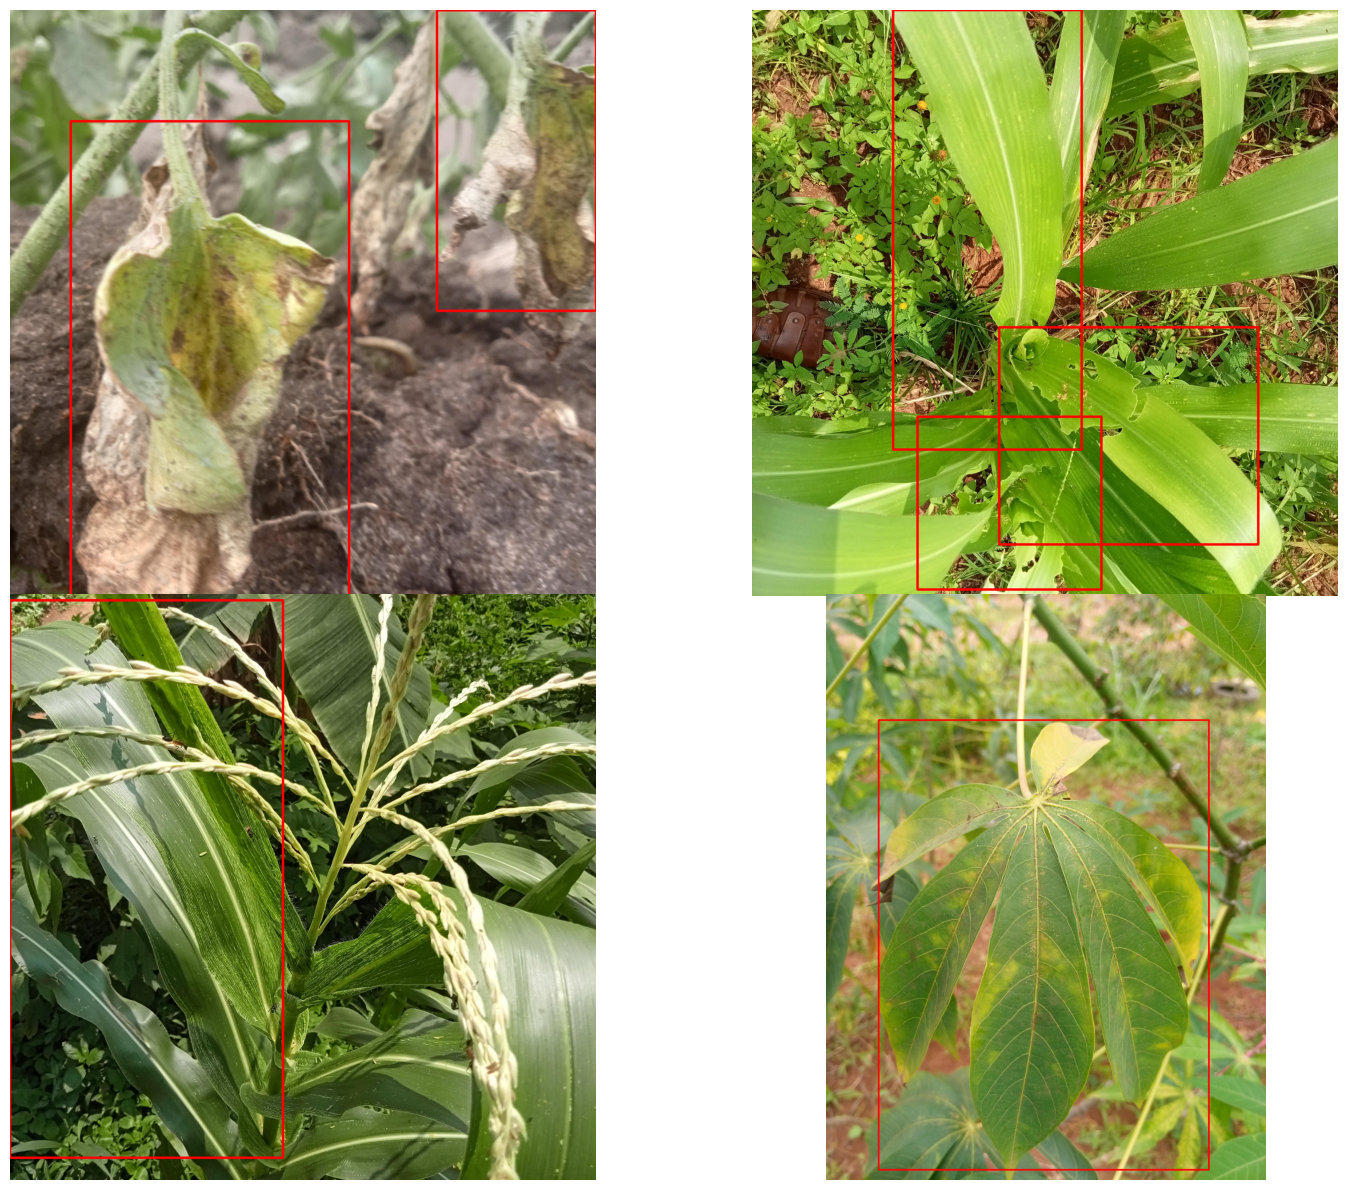

In [8]:
# Visualize a few training images.
plot(
    image_paths = 'datasets/FieldPlant/train/images', 
    label_paths = 'datasets/FieldPlant/train/labels',
    num_samples=4,
)

In [9]:
# Splits dataset into train, validate, and test based on a ratio

from tqdm import tqdm
from pathlib import Path

DATASETS_DIR = Path("datasets/FieldPlant/train")

IMG_FORMATS = 'bmp', 'dng', 'jpeg', 'jpg', 'mpo', 'png', 'tif', 'tiff', 'webp', 'pfm'  # include image suffixes

def img2label_paths(img_paths):
    # Define label paths as a function of image paths
    sa, sb = f'{os.sep}images{os.sep}', f'{os.sep}labels{os.sep}'  # /images/, /labels/ substrings
    return [sb.join(x.rsplit(sa, 1)).rsplit('.', 1)[0] + '.txt' for x in img_paths]

def autosplit(path=DATASETS_DIR / 'images', weights=(0.9, 0.1, 0.0), annotated_only=False):
    """ Autosplit a dataset into train/val/test splits and save path/autosplit_*.txt files
    Usage: from utils.dataloaders import *; autosplit()
    Arguments
        path:            Path to images directory
        weights:         Train, val, test weights (list, tuple)
        annotated_only:  Only use images with an annotated txt file
    """
    path = Path(path)  # images dir
    files = sorted(x for x in path.rglob('*.*') if x.suffix[1:].lower() in IMG_FORMATS)  # image files only
    n = len(files)  # number of files
    random.seed(0)  # for reproducibility
    indices = random.choices([0, 1, 2], weights=weights, k=n)  # assign each image to a split

    txt = ['autosplit_train.txt', 'autosplit_val.txt', ]  # 2 txt files
    for x in txt:
        if (path.parent / x).exists():
            (path.parent / x).unlink()  # remove existing

    print(f'Autosplitting images from {path}' + ', using *.txt labeled images only' * annotated_only)
    for i, img in tqdm(zip(indices, files), total=n):
        if not annotated_only or Path(img2label_paths([str(img)])[0]).exists():  # check label
            with open(path.parent / txt[i], 'a') as f:
                f.write(f'./{img.relative_to(path.parent).as_posix()}' + '\n')  # add image to txt file


autosplit()

Autosplitting images from datasets/FieldPlant/train/images


100%|██████████████████████████████████████████████████████████████████████████████| 5156/5156 [00:35<00:00, 145.07it/s]


Ultralytics YOLOv8.0.205 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/mnt/c/Users/shaun/Documents/capstone/plant_disease_detection/datasets/FieldPlant/data.yaml, epochs=250, patience=50, batch=32, imgsz=1280, save=True, save_period=-1, cache=ram, device=None, workers=8, project=None, name=plant_detection_1280-250-32_yolov8n4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment

ClearML Task: created new task id=d8c90a0ef7914add9414ab80e789b196
2023-11-03 02:57:39,637 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/43e74531e89841a88cc028596cf9073c/experiments/d8c90a0ef7914add9414ab80e789b196/output/log


ClearML Initialized a new task. If you want to run remotely, please add clearml-init and connect your arguments before initializing YOLO.
TensorBoard: Start with 'tensorboard --logdir runs/detect/plant_detection_1280-250-32_yolov8n4', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
train: Scanning /mnt/c/Users/shaun/Documents/capstone/plant_disease_detection/datasets/FieldPlant/train/labels... 4193 i

ClearML results page: https://app.clear.ml/projects/43e74531e89841a88cc028596cf9073c/experiments/d8c90a0ef7914add9414ab80e789b196/output/log
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


train: Scanning /mnt/c/Users/shaun/Documents/capstone/plant_disease_detection/datasets/FieldPlant/train/labels... 4626 i
train: New cache created: /mnt/c/Users/shaun/Documents/capstone/plant_disease_detection/datasets/FieldPlant/train/labels.cache
train: Caching images (17.6GB ram): 100%|██████████| 4626/4626 [01:03<00:00, 73.01it/s]
val: Scanning /mnt/c/Users/shaun/Documents/capstone/plant_disease_detection/datasets/FieldPlant/train/labels... 530 imag
val: New cache created: /mnt/c/Users/shaun/Documents/capstone/plant_disease_detection/datasets/FieldPlant/train/labels.cache
val: Caching images (2.1GB ram): 100%|██████████| 530/530 [00:07<00:00, 72.86it/s]
Plotting labels to runs/detect/plant_detection_1280-250-32_yolov8n4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000

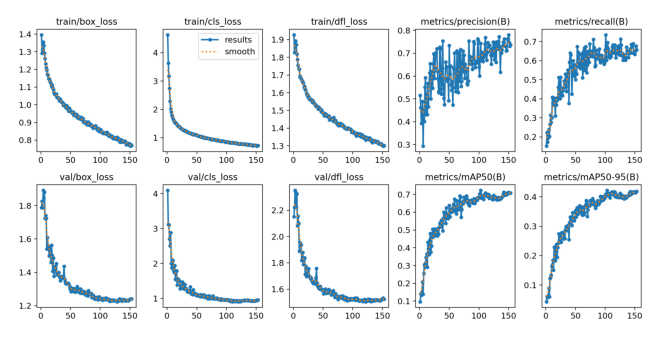

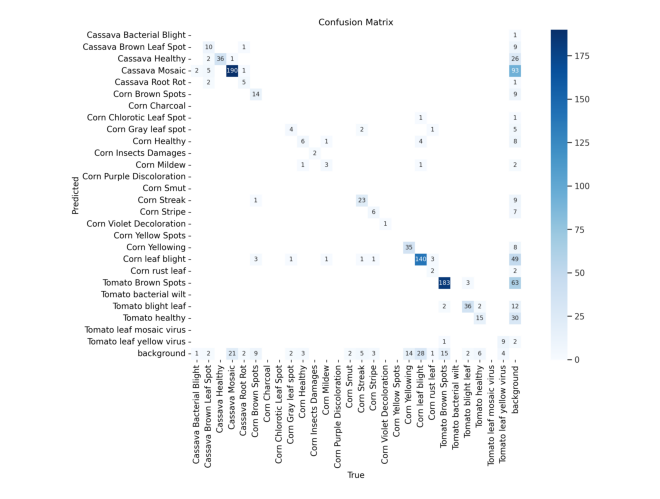

2023-11-03 05:51:42,980 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/YOLOv8/plant_detection_1280-250-32_yolov8n4.d8c90a0ef7914add9414ab80e789b196/models/best.pt


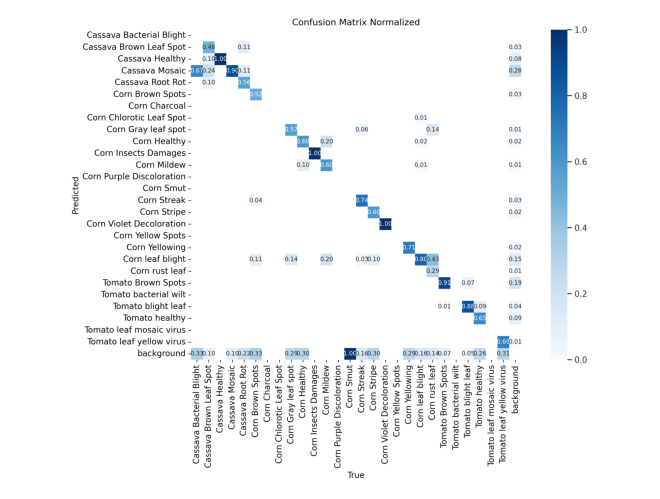

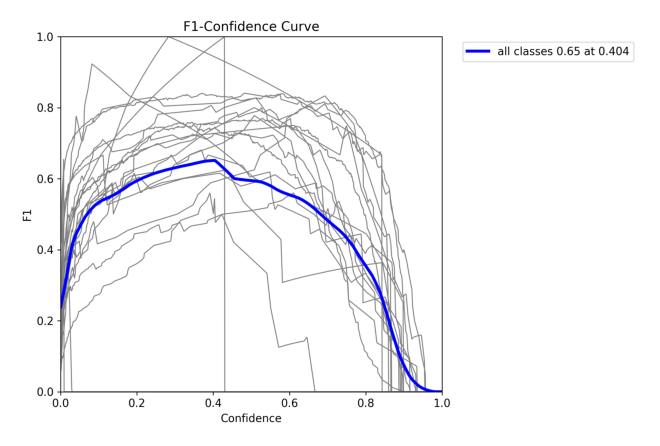

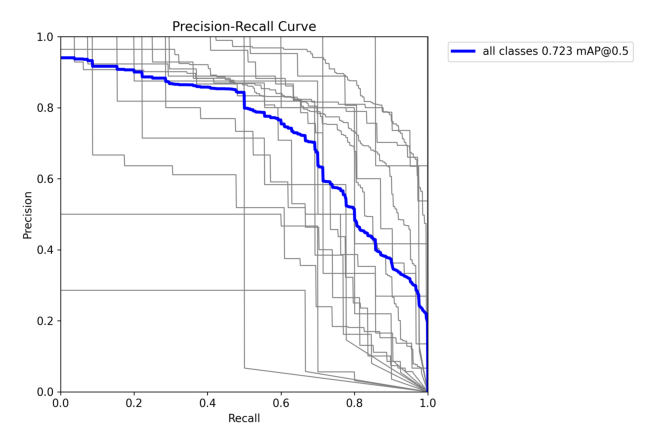

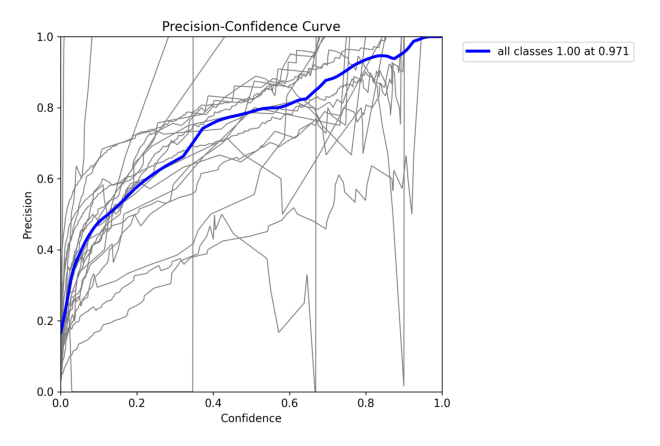

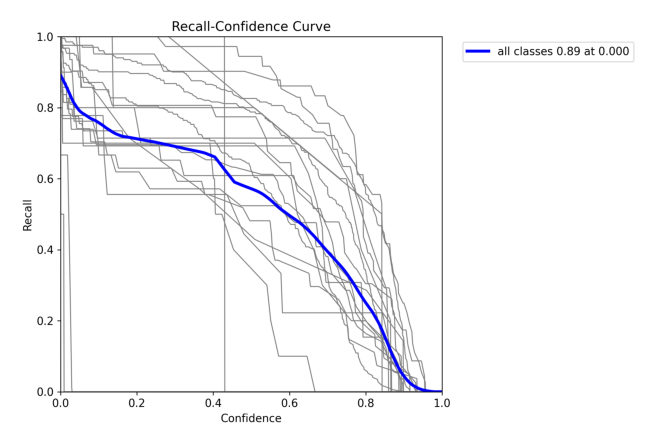

In [10]:
from datetime import datetime

OUTPUT_MODEL_NAME = 'plant_detection' + datetime.now().strftime("%Y-%m-%d-%H-%M-%S") 

# Load the model
model = YOLO('yolov8n.pt')

# Train the model
results = model.train(
    data = '/mnt/c/Users/shaun/Documents/capstone/plant_disease_detection/datasets/FieldPlant/data.yaml',
    imgsz = 1280,
    epochs = 250,
    batch = 32, # Use -1 for autobatch if you are unsure of your vram size
    cache = 'ram', # comment this out if you don't have at least 64gb of ram
    name = OUTPUT_MODEL_NAME
)

In [16]:
# Load model trained in previous cell
model = YOLO('runs/detect/' + OUTPUT_MODEL_NAME + '/weights/best.pt')

metrics = model.val() # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

Ultralytics YOLOv8.0.205 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
Model summary (fused): 168 layers, 3010913 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /mnt/c/Users/shaun/Documents/capstone/plant_disease_detection/datasets/FieldPlant/train/labels.cache... 53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:08<
                   all        530        884      0.739      0.672       0.72      0.422
Cassava Bacterial Blight        530          3          1          0        0.2       0.18
Cassava Brown Leaf Spot        530         21      0.653      0.571       0.66      0.469
       Cassava Healthy        530         36      0.617      0.972      0.855      0.648
        Cassava Mosaic        530        212      0.691      0.821        0.8      0.529
      Cassava Root Rot        530          9      0.685      0.556      0.606      0.438
      Corn Brown Spots        530      

array([    0.17966,     0.46889,     0.64767,     0.52893,     0.43829,       0.285,     0.42198,     0.42198,     0.46577,     0.17353,     0.44804,      0.4052,     0.42198,     0.25661,     0.47285,     0.31348,      0.4975,     0.42198,     0.39519,     0.35552,      0.4581,     0.76758,     0.42198,     0.55969,
           0.31666,     0.42198,     0.42751])

In [17]:
model = YOLO('runs/detect/' + OUTPUT_MODEL_NAME + '/weights/best.pt')

results = model.predict(
    source = '/mnt/c/Users/shaun/Documents/capstone/plant_disease_detection/datasets/FieldPlant/train/autosplit_val.txt',
    imgsz = 1280,
    name = OUTPUT_MODEL_NAME + '_infer',
    show_labels = False
)


image 1/530 /mnt/c/Users/shaun/Documents/capstone/plant_disease_detection/datasets/FieldPlant/train/images/Coloration_rouge_feuilles-4-_jpg.rf.760d056499f367f4dd19aeee7b31740b.jpg: 1280x960 1 Corn Violet Decoloration, 52.0ms
image 2/530 /mnt/c/Users/shaun/Documents/capstone/plant_disease_detection/datasets/FieldPlant/train/images/IMG20221216154023_jpg.rf.39cd1b7c2e84823a41e33afcc9c901f9.jpg: 1280x960 1 Corn leaf blight, 12.5ms
image 3/530 /mnt/c/Users/shaun/Documents/capstone/plant_disease_detection/datasets/FieldPlant/train/images/IMG20221216154024_jpg.rf.ee25816b701d9259cbbab7ebb3979da7.jpg: 1280x960 1 Corn leaf blight, 12.9ms
image 4/530 /mnt/c/Users/shaun/Documents/capstone/plant_disease_detection/datasets/FieldPlant/train/images/IMG20221216154034_jpg.rf.0238d2426e93b78989834853807a7568.jpg: 1280x960 1 Corn leaf blight, 13.4ms
image 5/530 /mnt/c/Users/shaun/Documents/capstone/plant_disease_detection/datasets/FieldPlant/train/images/IMG20221216154202_jpg.rf.26e7dc88b2e6f84413941e07


image 1/1 /mnt/c/Users/shaun/Documents/capstone/plant_disease_detection/datasets/FieldPlant/train/images/Tomate_Taches_Brunes-317-_jpg.rf.a80df2bdf69f409cd1b3d42313a4c823.jpg: 1280x960 5 Tomato Brown Spotss, 10.1ms
Speed: 4.8ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 960)

image 1/1 /mnt/c/Users/shaun/Documents/capstone/plant_disease_detection/datasets/FieldPlant/train/images/Mais_Rayure_-94-_jpg.rf.32e103abfb3c601965b31de83898953d.jpg: 1280x576 1 Corn Stripe, 6.6ms
Speed: 4.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 576)

image 1/1 /mnt/c/Users/shaun/Documents/capstone/plant_disease_detection/datasets/FieldPlant/train/images/IMG_20221118_090005_523_jpg.rf.22cf89310a79dde0a7eabb35a08f48dd.jpg: 1280x960 6 Tomato blight leafs, 1 Tomato healthy, 16.6ms
Speed: 5.5ms preprocess, 16.6ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 960)

image 1/1 /mnt/c/Users/shaun/Documents/capstone/plant_diseas

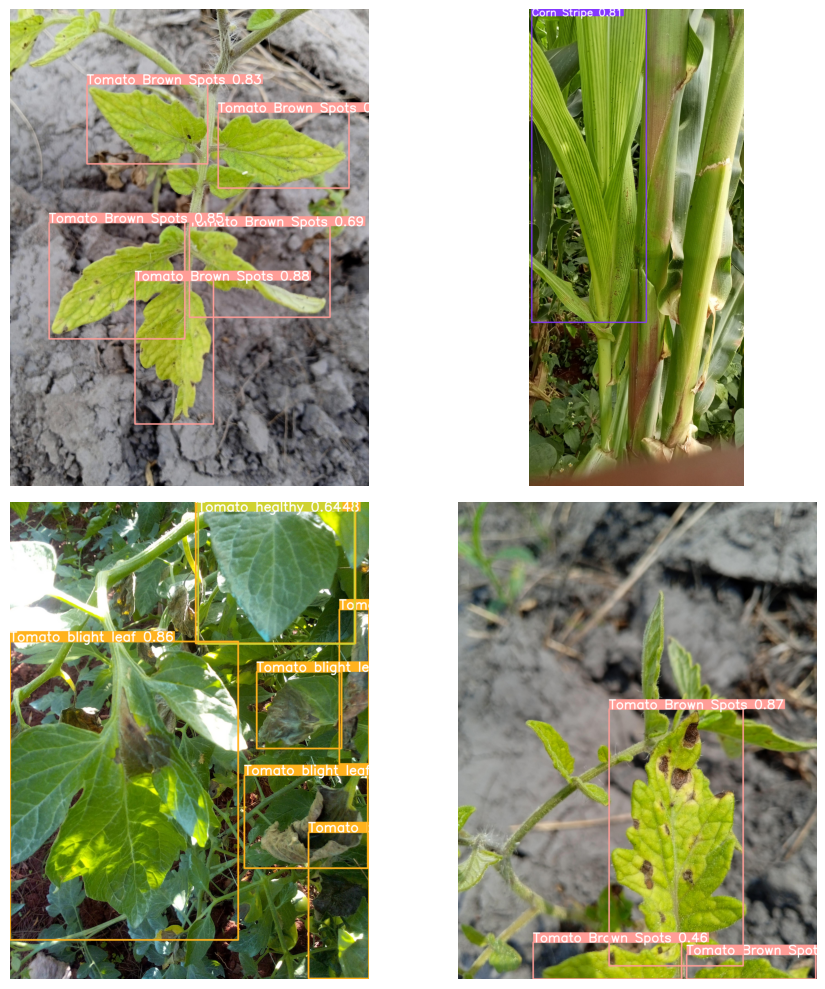

In [21]:
from PIL import Image

model = YOLO('runs/detect/' + OUTPUT_MODEL_NAME + '/weights/best.pt')

# Define the folder containing images
image_folder = '/mnt/c/Users/shaun/Documents/capstone/plant_disease_detection/datasets/FieldPlant/train/images/'

# Get all the image paths from the folder
image_paths = glob.glob(f'{image_folder}/*.jpg')  # Adjust the pattern if necessary

# Select four random image paths
random_image_paths = random.sample(image_paths, min(len(image_paths), 4))

# Create a figure with subplots arranged in 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # Adjust the figsize if necessary

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Run inference and show results for each of the four random images
for idx, image_path in enumerate(random_image_paths):
    # Run inference on the image
    results = model(image_path)

    # Show the results
    for r in results:
        im_array = r.plot()  # plot a BGR numpy array of predictions
        im = Image.fromarray(im_array[..., ::-1])  # convert to RGB PIL image
        axes_flat[idx].imshow(im)
        axes_flat[idx].axis('off')  # Hide the axis

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()